# **Cervical Spine Detection Solution Part 1**

The **goal of this competition** is **to identify fractures in CT scans of the cervical spine (neck) at both the level of a single vertebrae and the entire patient**. Quickly detecting and determining the location of any vertebral fractures is essential to prevent neurologic deterioration and paralysis after trauma.

> 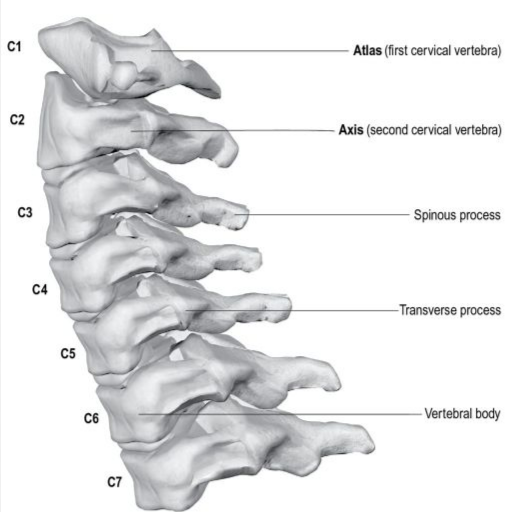](http://i1.wp.com/musculoskeletalkey.com/wp-content/uploads/2018/02/image00410.jpeg?w=512)

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
from tqdm.notebook import tqdm
from pathlib import Path
from collections import Counter
tqdm.pandas()


import seaborn as sns
import os
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from pprint import pprint
import nibabel as nib
from glob import glob



In [ ]:
 !pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless"
    
# pydicom is a pure Python package for working with DICOM files such as medical images, reports, and radiotherapy objects.
# pylibjpeg - A Python framework for decoding JPEG and decoding/encoding DICOM RLE data, with a focus on supporting pydicom.

# Loading the Dataset

In [ ]:
paths = {
    'train_df': Path('../input/rsna-2022-cervical-spine-fracture-detection/train.csv'),
    'train_bbox': Path('../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv'),
    'train_images': Path('../input/rsna-2022-cervical-spine-fracture-detection/train_images'),
    'train_nifti_segments': Path('../input/rsna-2022-cervical-spine-fracture-detection/segmentations'),
    'test_df': Path('../input/rsna-2022-cervical-spine-fracture-detection/test.csv'),
    'test_images': Path('../input/rsna-2022-cervical-spine-fracture-detection/test_images')
}

In [ ]:
train_df = pd.read_csv(paths['train_df'])
test_df = pd.read_csv(paths['test_df'])

# Basic EDA

In [ ]:
train_df.head()

In [ ]:
train_df.info() 

In [ ]:
train_df.describe() 

In [ ]:
train_df.columns 

In [ ]:
train_df['patient_overall'].value_counts() 

In [ ]:
train_df.corr()

In [ ]:
# Get the list of verterbraes
verterbraes = list(train_df.columns[-7:])
verterbraes

In [ ]:
print('Number of patients in the training dataset:', len(train_df.StudyInstanceUID.unique()))

# Data Visualization

In [ ]:
plt.figure(figsize=(10, 5))
ax1 = sns.countplot(x='patient_overall', data=train_df)
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures distribution by patient')
plt.ylim([0, 1200])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
ax3 = sns.countplot(x=train_df[verterbraes].sum(axis=1))
for container in ax3.containers:
    ax3.bar_label(container)
plt.title('Number of fractures by patient')
plt.ylim([0, 1200])
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(train_df[verterbraes].corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlations')
plt.show()

This correlation indicates that patients, who has fracture in an any verterbrae, may have another fracture in an adjacent verterbrae.

In [ ]:
# Adding an additional column to store total number of fractures
train_df['total_fractures'] = train_df.loc[:,[f"C{i}" for i in range(1,8)]].sum(axis=1)

In [ ]:
# Adding a column to store the segment path of the patient's folder
train_df['segment_path'] = train_df['StudyInstanceUID'].map(lambda x: paths['train_images']/x)

In [ ]:
max(train_df['total_fractures'])

#1.2.826.0.1.3680043.25071 #1.2.826.0.1.3680043.25772

Two pateients have maximum fractures

In [ ]:
train_df[train_df['StudyInstanceUID'] == '1.2.826.0.1.3680043.25772']

In [ ]:
train_df[train_df['StudyInstanceUID'] == '1.2.826.0.1.3680043.25071']

In [ ]:
# Adding a column to store number of slices
def num_slices(path):
    slices = list(path.glob('*'))
    return len(slices)

train_df['num_slices'] = train_df['segment_path'].progress_map(num_slices)
train_df['num_slices'] = train_df['num_slices'].astype('int')

In [ ]:
train_df.head()

# Basic EDA on Train Bounding Box

In [ ]:
train_bbox = pd.read_csv(paths['train_bbox'])


In [ ]:
train_bbox.head()

In [ ]:
train_bbox.info()

In [ ]:
train_bbox.describe()